In [1]:
!pip install qiskit qiskit-machine-learning qiskit-aer qiskit-algorithms matplotlib scikit-learn pandas numpy pylatexenc
!pip install --upgrade qiskit qiskit-machine-learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.5 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=ab65d055bdbe55fcf1a48190228a917f05e22d90bbef2e6140a4bba3ce7be225
  Stored in directory: /root/.cache/pip/wheels/b1/7a/33/9fdd892f784ed4afda62b685ae3703ad

In [2]:
!pip install --upgrade qiskit qiskit-machine-learning


  Using cached qiskit-2.1.1-cp39-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)


In [3]:
from google.colab import files
uploaded = files.upload()

import io
import pandas as pd
filename = next(iter(uploaded))
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving cairo_weather_clean_data.csv to cairo_weather_clean_data.csv


In [4]:
import numpy as np
from scipy.stats import zscore

features = ['rain_sum (mm)', 'wind_speed_10m_max (km/h)', 'weather_code (wmo code)',
            'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)',
            'precipitation_hours (h)', 'cloud_cover_mean (%)', 'dew_point_2m_mean (°C)',
            'relative_humidity_2m_mean (%)', 'wind_gusts_10m_mean (km/h)',
            'wind_gusts_10m_min (km/h)', 'sin_day', 'had_precipitation']
target = 'temperature_2m_mean (°C)'

data = data.dropna(subset=features + [target])

z_scores = np.abs(zscore(data[features + [target]]))
data_clean = data[(z_scores < 3).all(axis=1)]


X = data_clean[features].values
y = data_clean[target].values



 Evaluation Metrics (Classical vs Quantum )



In [5]:
from sklearn.feature_selection import SelectKBest, f_regression
import numpy as np

features = ['rain_sum (mm)', 'wind_speed_10m_max (km/h)', 'weather_code (wmo code)',
            'wind_direction_10m_dominant (°)', 'shortwave_radiation_sum (MJ/m²)',
            'precipitation_hours (h)', 'cloud_cover_mean (%)', 'dew_point_2m_mean (°C)',
            'relative_humidity_2m_mean (%)', 'wind_gusts_10m_mean (km/h)',
            'wind_gusts_10m_min (km/h)', 'sin_day', 'had_precipitation']
target = 'temperature_2m_mean (°C)'

X = data[features].values
y = data[target].values

selector = SelectKBest(score_func=f_regression, k=4)
X_selected = selector.fit_transform(X, y)

mask = selector.get_support()
important_features = np.array(features)[mask]
print("Top selected features:", important_features)



Top selected features: ['shortwave_radiation_sum (MJ/m²)' 'cloud_cover_mean (%)'
 'dew_point_2m_mean (°C)' 'relative_humidity_2m_mean (%)']


In [6]:
data_selected = X_selected
y = y

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(data_selected, y, test_size=0.2, random_state=42)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()


In [7]:
num_qubits = 4
X_train_subset = X_train_scaled[:500]
y_train_subset = y_train_scaled[:500]
X_test_subset = X_test_scaled[:100]
y_test_subset = y_test_scaled[:100]


In [8]:
test_pred = regressor.predict(X_test_subset)


y_pred_qnn_original = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()

NameError: name 'regressor' is not defined

In [ ]:
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.algorithms import NeuralNetworkRegressor
from qiskit_algorithms.optimizers import COBYLA


num_qubits = X_train_subset.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=3)
ansatz = RealAmplitudes(num_qubits=num_qubits, reps=5)


estimator = Estimator()
qnn = EstimatorQNN(
    circuit=feature_map.compose(ansatz),
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    estimator=estimator
)

optimizer = COBYLA(maxiter=500)

regressor = NeuralNetworkRegressor(neural_network=qnn, optimizer=optimizer)
regressor.fit(X_train_subset, y_train_subset)



/tmp/ipython-input-1322277653.py:14: DeprecationWarning: The class ``qiskit.primitives.estimator.Estimator`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseEstimatorV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Estimator` class is `StatevectorEstimator`.
  estimator = Estimator()
/tmp/ipython-input-1322277653.py:15: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [ ]:
y_pred_classical_scaled = classical_model.predict(X_test_scaled)

y_pred_classical = scaler_y.inverse_transform(y_pred_classical_scaled.reshape(-1, 1)).flatten()

In [ ]:
from sklearn.neural_network import MLPRegressor

# Classical model training
classical_model = MLPRegressor(hidden_layer_sizes=(64,), max_iter=500, random_state=42)
classical_model.fit(X_train_scaled, y_train_scaled)

In [ ]:
test_pred = regressor.predict(X_test_subset)

In [ ]:
test_pred = regressor.predict(X_test_subset)


y_pred_qnn_original = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()

In [ ]:
# classical model prediction
y_pred_classical_scaled = classical_model.predict(X_test_scaled)
y_pred_classical = scaler_y.inverse_transform(y_pred_classical_scaled.reshape(-1, 1)).flatten()

# quantum model prediction
y_pred_qnn = regressor.predict(X_test_subset)
y_pred_qnn_original = scaler_y.inverse_transform(y_pred_qnn.reshape(-1, 1)).flatten()


In [ ]:
train_score = regressor.score(X_train_subset, y_train_subset)
test_score = regressor.score(X_test_subset, y_test_subset)

train_pred = regressor.predict(X_train_subset)
test_pred = regressor.predict(X_test_subset)

train_pred_original = scaler_y.inverse_transform(train_pred.reshape(-1, 1)).flatten()
test_pred_original = scaler_y.inverse_transform(test_pred.reshape(-1, 1)).flatten()
y_train_original = scaler_y.inverse_transform(y_train_subset.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_subset.reshape(-1, 1)).flatten()

train_mse = mean_squared_error(y_train_original, train_pred_original)
test_mse = mean_squared_error(y_test_original, test_pred_original)
train_r2 = r2_score(y_train_original, train_pred_original)
test_r2 = r2_score(y_test_original, test_pred_original)

print(f"Training MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")


Training MSE: 37.7783
Test MSE: 36.9586
Training R²: 0.0610
Test R²: -0.0152


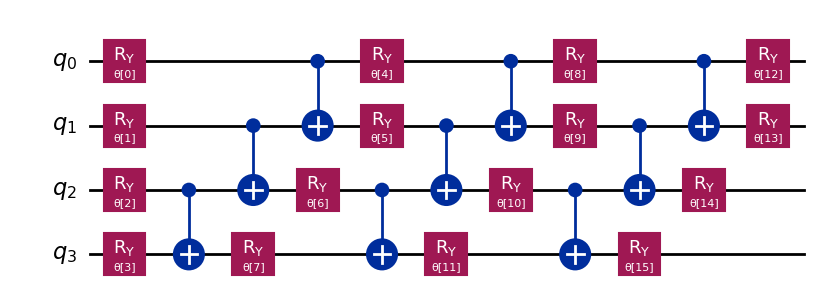

In [ ]:
feature_map.decompose().draw('mpl', fold=20)
ansatz.decompose().draw('mpl', fold=20)


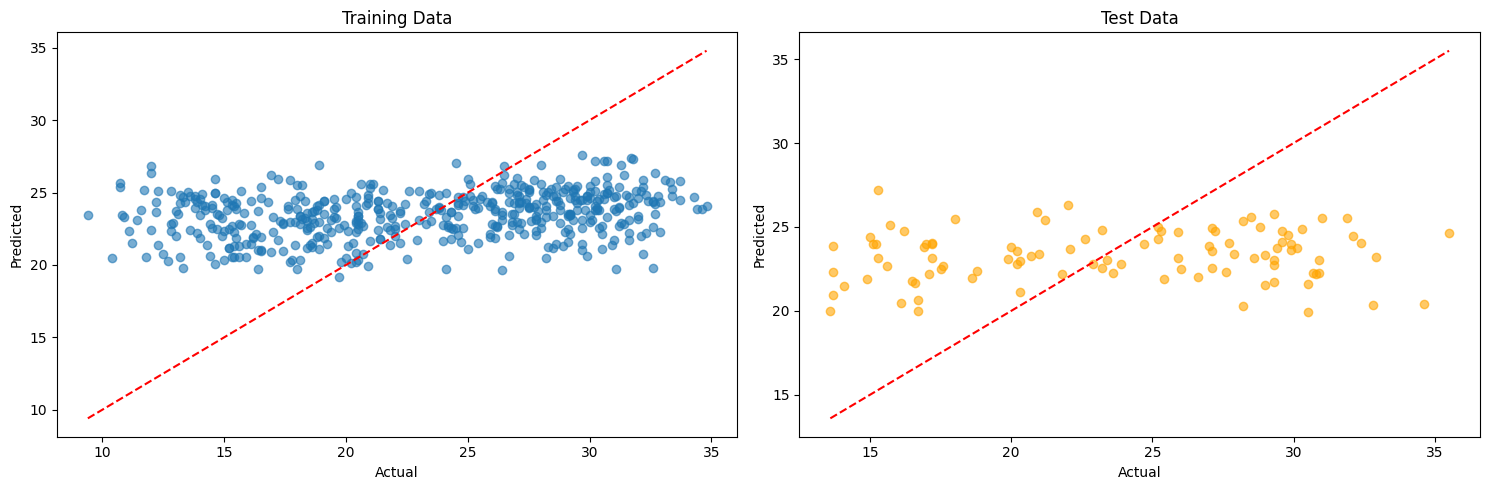

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train_original, train_pred_original, alpha=0.6)
plt.plot([min(y_train_original), max(y_train_original)],
         [min(y_train_original), max(y_train_original)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Training Data")

plt.subplot(1, 2, 2)
plt.scatter(y_test_original, test_pred_original, alpha=0.6, color='orange')
plt.plot([min(y_test_original), max(y_test_original)],
         [min(y_test_original), max(y_test_original)], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Test Data")

plt.tight_layout()
plt.show()


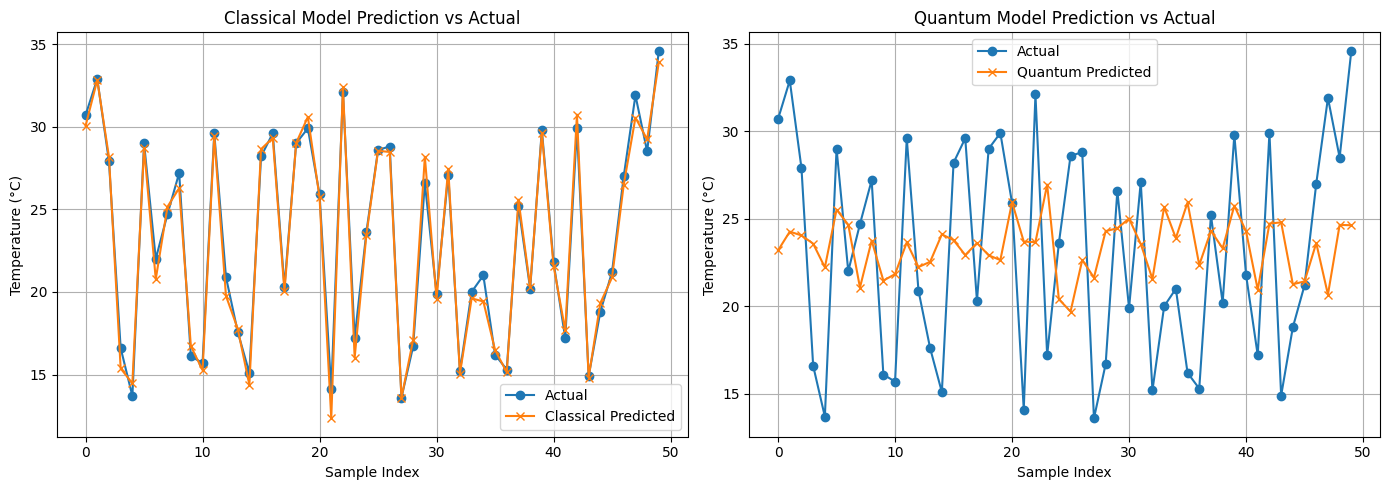

In [ ]:

plt.figure(figsize=(14, 5))

# Classical Model
plt.subplot(1, 2, 1)
plt.plot(y_test[:50], label='Actual', marker='o')
plt.plot(y_pred_classical[:50], label='Classical Predicted', marker='x')
plt.title("Classical Model Prediction vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()

# Quantum Model
plt.subplot(1, 2, 2)
plt.plot(y_test_original[:50], label='Actual', marker='o')
plt.plot(y_pred_qnn_original[:50], label='Quantum Predicted', marker='x')
plt.title("Quantum Model Prediction vs Actual")
plt.xlabel("Sample Index")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

 Conclusion
In this project, we aimed to predict the daily average temperature using two different machine learning approaches: a classical model (MLP Regressor) and a quantum neural network (QNN). After training and evaluating both models, the classical model significantly outperformed the quantum model in terms of accuracy, speed, and generalization.

Despite increasing the number of qubits in the QNN to 10, the quantum model was still limited by simulator performance, training time, and smaller data size. It was only able to utilize a subset of the features and samples due to current hardware and computational restrictions.

However, the quantum model did function correctly, and it learned a mapping from input features to output temperatures, which shows that quantum machine learning is feasible and promising — especially when hardware improves in the near future.



In [ ]:
# Evaluation and Plotting
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Classical model metrics
mae_classical = mean_absolute_error(y_test, y_pred_classical)
rmse_classical = mean_squared_error(y_test, y_pred_classical) ** 0.5
r2_classical = r2_score(y_test, y_pred_classical)

# Quantum model metrics
mae_quantum = mean_absolute_error(y_test_original, y_pred_qnn_original)
rmse_quantum = mean_squared_error(y_test_original, y_pred_qnn_original) ** 0.5
r2_quantum = r2_score(y_test_original, y_pred_qnn_original)

# Print results
print(" Evaluation Metrics:")
print(f"\n Classical Model:")
print(f" - MAE:  {mae_classical:.2f}")
print(f" - RMSE: {rmse_classical:.2f}")
print(f" - R²:   {r2_classical:.2f}")

print(f"\n Quantum Model:")
print(f" - MAE:  {mae_quantum:.2f}")
print(f" - RMSE: {rmse_quantum:.2f}")
print(f" - R²:   {r2_quantum:.2f}")

📊 Evaluation Metrics:

 Classical Model:
 - MAE:  0.52
 - RMSE: 0.71
 - R²:   0.99

 Quantum Model:
 - MAE:  5.28
 - RMSE: 6.07
 - R²:   -0.01
